## <a class="anchor" id="main">FoCS Lab</a>
### Contributors: Marco Distrutti, Santosh Anand

* [1 Normalization](#normalize)
* [2 Duration Field](#duration)
* [3 Search lenders](#search-lenders)
* [4 How many loans](#borrowers)
* [5 Overall amount](#overall-amount)
* [6 Overall percentage](#overall-percentage)
* [7 Overall by country/year](#year-overall-percentage)
* [8 Lenders overall](#lenders-overall)
* [9 Country, lent vs borrowed](#country-lent-borrowed)
* [10 Country, Difference lent-borrowed in respect of population](#country-lent-borrowed-population)
* [11 Country, Difference lent-borrowed in respect of population below poverty line](#country-lent-borrowed-population-line)
* [12 Country, For each year, compute the total amount of loans](#country-loan)
* [13 For each repayment_interval, lenders money in that repayment_interval state](#repayment-interval)
* [14 Average amount by lender occupation](#lender-occupation)
* [15 Cluster the loans according to the year-month of disburse time](#cluster-disburse-time)
* [16 For each country, compute its overall GNI](#country-gni)
* [17 Find the country with the highest rate of irregular repayment interval](#country-irregular-repayment)
* [18 Find the country with the highest fraction of loaned amount with irregular repayment interval.](#country-frac-irregular-repayment)

In [1]:
import pandas as pd
import numpy as np
import itertools
import time

start_time = time.time()

df_loan_lenders = pd.read_csv('kiva-kaggle/loans_lenders.csv')
df_loan_lenders_original = df_loan_lenders

In [2]:
loan_lenders = df_loan_lenders
df_loan_lenders

,loan_id,lenders
0,483693,"muc888, sam4326, camaran3922, lachheb1865, reb..."
1,483738,"muc888, nora3555, williammanashi, barbara5610,..."
2,485000,"muc888, terrystl, richardandsusan8352, sherri4..."
3,486087,"muc888, james5068, rudi5955, daniel9859, don92..."
4,534428,"muc888, niki3008, teresa9174, mike4896, david7..."
...,...,...
1387427,678999,"michael43411218, carol5987, gooddogg1, chris41..."
1387428,1207353,"rjhoward1986, jeffrey6870, trolltech4460, elys..."
1387429,1206220,"vicky7746, gooddogg1, fairspirit, craig9729960..."
1387430,1206425,"rich6705, sergiiy9766, angela7509, barbara5610..."


## 1 <a class="anchor" id="normalize">Normalization</a>
#### Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.
[⇑ index](#main)

Using **Vectorized** operations our computations are extremly faster then looping over the dataset because Vectorized operations are heavily implemented in **C** procedures. So the strategy is to create both vectors (loan_id and lender) separatly and loan_id is generated by repeating id with vectorized products.

In [3]:
%%time

#FIRST 
## SANTOSH -> Note that the lenders are seperated by ", " 
lenders = [lender for lenders in df_loan_lenders['lenders'] for lender in lenders.split(', ')]
# lenders


Wall time: 3.33 s


In [4]:
#SECOND AXIS - using vectorized operations we boost the performance using internal opimized C procedures
loan_ids = [loan_id for loan_id in df_loan_lenders['loan_id']]
#loan_ids

In [5]:
%%time
cardinality = [len(lenders.split(", ")) for lenders in df_loan_lenders['lenders']]
# cardinality


Wall time: 1.85 s


In [6]:
%%time

#create a new list with repeated ids for each loan in the same original row
flatted_ids = list(itertools.chain(*[[loan_ids[i]] * cardinality[i] for i in range(0, len(loan_ids))]))
# flatted_ids


Wall time: 5.57 s


In [7]:
#DATAFRAME
df_loan_lenders = pd.DataFrame({'loan_id':flatted_ids, 'lender':lenders})

#More then 28 milions of records
df_loan_lenders

,loan_id,lender
0,483693,muc888
1,483693,sam4326
2,483693,camaran3922
3,483693,lachheb1865
4,483693,rebecca3499
...,...,...
28293926,1206425,trogdorfamily7622
28293927,1206425,danny6470
28293928,1206425,don6118
28293929,1206486,alan5175


## 2 <a class="anchor" id="duration">Duration</a>
#### For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time. If any of those two dates is missing, also the duration must be missing.
[⇑ index](#main)

Specifying column names and types we can avoid unnecessary data and boost performance because we can read only what we need and the interpreter won't infer data types during the scan.

In [8]:
%%time
df_loans = pd.read_csv('kiva-kaggle/loans.csv',
                       usecols=['loan_id', 'disburse_time', 'planned_expiration_time', 'country_code', 'country_name', 'loan_amount', 'num_lenders_total', 'funded_amount', 'repayment_interval'],
                       dtype={'loan_id': np.int32, 'disburse_time': 'str', 'planned_expiration_time': 'str', 'country_code': 'str', 'country_name': 'str', 'loan_amount': 'float', 'num_lenders_total': np.int32, 'funded_amount': 'float', 'repayment_interval': 'str'})

#it should be possible to parse datetime by specifying a lambda parser in read_csv method but
#with vectorized operations we saved more then 2 minutes for this loading.
df_loans['planned_expiration_time'] = pd.to_datetime(df_loans['planned_expiration_time'])
df_loans['disburse_time']= pd.to_datetime(df_loans['disburse_time'])
df_loans["duration"] = df_loans['planned_expiration_time'] - df_loans['disburse_time']

df_loans[['disburse_time', 'planned_expiration_time', 'duration']]

Wall time: 10.3 s


,disburse_time,planned_expiration_time,duration
0,2013-12-22 08:00:00+00:00,2014-02-14 03:30:06+00:00,53 days 19:30:06
1,2013-12-20 08:00:00+00:00,2014-03-26 22:25:07+00:00,96 days 14:25:07
2,2014-01-09 08:00:00+00:00,2014-02-15 21:10:05+00:00,37 days 13:10:05
3,2014-01-17 08:00:00+00:00,2014-02-21 03:10:02+00:00,34 days 19:10:02
4,2013-12-17 08:00:00+00:00,2014-02-13 06:10:02+00:00,57 days 22:10:02
...,...,...,...
1419602,2015-11-23 08:00:00+00:00,2016-01-02 01:00:03+00:00,39 days 17:00:03
1419603,2015-11-24 08:00:00+00:00,2016-01-02 16:40:07+00:00,39 days 08:40:07
1419604,2015-11-13 08:00:00+00:00,2016-01-03 22:20:04+00:00,51 days 14:20:04
1419605,2015-11-03 08:00:00+00:00,2016-01-05 08:50:02+00:00,63 days 00:50:02


## 3 <a class="anchor" id="search-lenders">Search lenders</a>
#### Find the lenders that have funded at least twice.
[⇑ index](#main)

Pandas aggregation methods give us the possibility to create grouped dataframe and apply aggregation functions such as the occurrences counting.

In [9]:
%%time

df_lenders_multifunder = df_loan_lenders.groupby(['lender']).count().rename(columns={"loan_id": "funds"}).sort_values(by=["funds"])
df_lenders_multifunder = df_lenders_multifunder[df_lenders_multifunder["funds"] >= 2]
df_lenders_multifunder

Wall time: 9.26 s


,funds
lender,
clifford1150,2
sofe8281,2
barbi3519,2
ernesto5398,2
awgmqi9423,2
...,...
themissionbeltco,81434
nms,104314
gmct,128159


## 4 <a class="anchor" id="borrowers">How many loans</a>
#### For each country, compute how many loans have involved that country as borrowers.
[⇑ index](#main)

There is a problem with Namibia country, in all records corresponding to this Country we haven't the **country_code**, I take this opportunity to upload country data but we noticed that even from country_stats.csv Namibia has null value in **country_code**. So we decided to force the setting of Namibia iso 2chars code to 'NA' in order to have consistent data in the original **df_loans** dataset.

In [10]:
df_loans[df_loans["country_code"].isnull()][['loan_id', 'country_code', 'country_name']]

,loan_id,country_code,country_name
82889,991853,NaN,Namibia
156970,513472,NaN,Namibia
598087,851360,NaN,Namibia
684876,1068159,NaN,Namibia
971827,998555,NaN,Namibia
1134818,1147866,NaN,Namibia
1214923,851368,NaN,Namibia
1281022,1147852,NaN,Namibia
1415763,1068167,NaN,Namibia


In [11]:
df_countries = pd.read_csv('kiva-kaggle/country_stats.csv')
df_countries[df_countries["country_code"].isnull()]

,country_name,country_code,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name
115,Namibia,NaN,NAM,Africa,Southern Africa,2533794,28.7,0.640007,65.062,11.657589,6.676,9769.848507,Namibia


In [12]:
#FIXING DF_LOANS
#it should be fixed applying a function to the dataset that will set a 'NA' value where a null value is found
#but we found this two step solution (divide two subsets and append them again) very faster against the apply function

#Vectorized operations are more optimized then the apply.

df_namibia = df_loans[df_loans["country_code"].isnull()]
df_namibia = df_namibia.assign(country_code=['NA'] * len(df_namibia))
df_loans = pd.concat([df_loans[df_loans["country_code"].notnull()], df_namibia])

In [13]:
%%time
df_countries_borrows = df_loans[['country_code', 'country_name', 'loan_id']].groupby(['country_name']).count().rename(columns={"loan_id": "borrows"}).sort_values(by=["borrows"])
df_countries_borrows

Wall time: 246 ms


,country_code,borrows
country_name,,
Mauritania,1,1
Papua New Guinea,1,1
Uruguay,1,1
Botswana,1,1
Canada,1,1
...,...,...
El Salvador,64037,64037
Cambodia,79701,79701
Peru,86000,86000


## 5 <a class="anchor" id="overall-amount">Overall amount</a>
#### For each country, compute the overall amount of money borrowed
[⇑ index](#main)

We noticed that funded_amount is different then loan_amount (in some cases it could be higher) and for that reason we consider the funded_amount as the borrowed amont, and when is higher then the loan_amount (12 times) it is considered as an over funding.

In [14]:
when_less  = len(df_loans[df_loans["funded_amount"] < df_loans["loan_amount"]])
when_equal = len(df_loans[df_loans["funded_amount"] == df_loans["loan_amount"]])
when_more  = len(df_loans[df_loans["funded_amount"] > df_loans["loan_amount"]])

print("TOTAL: " + str(when_less + when_equal + when_more))
print("LESS: " + str(when_less) + " | EQUAL = " + str(when_equal) + " | MORE = " + str(when_more))

TOTAL: 1419607
LESS: 64279 | EQUAL = 1355316 | MORE = 12


In [15]:
%%time
df_countries_borrowed = df_loans[['country_code', 'country_name', 'funded_amount']].groupby(['country_code', 'country_name'], as_index=False).sum().rename(columns={"funded_amount": "borrowed"}).sort_values(by=["borrowed"])
df_countries_borrowed

Wall time: 241 ms


,country_code,country_name,borrowed
87,VI,Virgin Islands,0.0
30,GZ,Gaza,5000.0
85,UY,Uruguay,8000.0
12,BW,Botswana,8000.0
29,GU,Guam,8700.0
...,...,...,...
40,KH,Cambodia,50829425.0
66,PY,Paraguay,53715200.0
38,KE,Kenya,63650255.0
60,PE,Peru,78702800.0


## 6 <a class="anchor" id="overall-amount">Overall percentage</a>
#### Like the previous point, but expressed as a percentage of the overall amount lent.
[⇑ index](#main)

In [16]:
total_borrowed = df_countries_borrowed.borrowed.sum()
#vectorized operation
total_borrowed_perc = (df_countries_borrowed.borrowed / total_borrowed) * 100

df_countries_borrowed_perc = pd.DataFrame({'country_name': df_countries_borrowed.country_name, 'borrowed':total_borrowed_perc})
df_countries_borrowed_perc

,country_name,borrowed
87,Virgin Islands,0.000000
30,Gaza,0.000442
85,Uruguay,0.000708
12,Botswana,0.000708
29,Guam,0.000770
...,...,...
40,Cambodia,4.497442
66,Paraguay,4.752779
38,Kenya,5.631843
60,Peru,6.963708


## 7 <a class="anchor" id="year-overall-percentage">Overall by country/year</a>
#### Like the three previous points, but split for each year (with respect to disburse time).
[⇑ index](#main)

The following dataset is the grouped amount by **country_name** and **year**. For the same reason explained in Execise 5 ew will use the funded amount as borrowed amount.

In [17]:
df_loans_year = df_loans[['country_name', 'disburse_time', 'funded_amount']].rename(columns={"funded_amount": "borrowed"})
# in according to not null values
df_loans_year = df_loans_year[df_loans_year.disburse_time.notnull()]
df_loans_year['year'] = df_loans_year.disburse_time.dt.year

df_countries_borrowed_year = df_loans_year.groupby(['country_name', 'year']).sum().sort_values(by=["borrowed"]).reset_index()
df_countries_borrowed_year

,country_name,year,borrowed
0,Paraguay,2018,25.0
1,Mexico,2018,50.0
2,Pakistan,2018,75.0
3,Philippines,2018,100.0
4,Bolivia,2018,350.0
...,...,...,...
743,Kenya,2015,9789250.0
744,Philippines,2014,13751850.0
745,Philippines,2015,15847375.0
746,Philippines,2016,15951625.0


We need the total amounts for each year

In [18]:
overall_years = df_loans_year.groupby(['year']).sum().reset_index()
overall_years

,year,borrowed
0,2005,102850.0
1,2006,1375175.0
2,2007,15439425.0
3,2008,39384425.0
4,2009,59477925.0
5,2010,72187300.0
6,2011,93601250.0
7,2012,115427450.0
8,2013,128301200.0
9,2014,146668375.0


## 8 <a class="anchor" id="lenders-overall">Lenders overall</a>
#### For each lender, compute the overall amount of money lent. For each loan that has more than one lender, you must assume that all lenders contributed the same amount.
[⇑ index](#main)

We have seen that **num_lenders_total**, that should represent the number of lenders in loan, is different from the real number of the lenders involved in datasets relationship. We can show here:

In [19]:
# Show the difference explained

df_loan_lenders_grouped = df_loan_lenders.groupby(["loan_id"]).count().rename(columns={"lender": "n_lenders"}).reset_index()
df_loan_lenders_merged = df_loans.merge(df_loan_lenders_grouped)
df_loan_lenders_merged_subset = df_loan_lenders_merged[["loan_id", "funded_amount", "num_lenders_total", "n_lenders"]]
df_loan_lenders_merged_subset

,loan_id,funded_amount,num_lenders_total,n_lenders
0,657307,125.0,3,3
1,657259,400.0,11,7
2,658010,400.0,16,14
3,659347,625.0,21,17
4,656933,425.0,15,14
...,...,...,...,...
1387423,998555,3325.0,126,116
1387424,1147866,5000.0,183,170
1387425,851368,4150.0,159,156
1387426,1147852,5100.0,183,174


In [20]:
# Add the funded_per_person column

funded_per_person = df_loan_lenders_merged_subset.funded_amount / df_loan_lenders_merged_subset.n_lenders
df_loan_lenders_merged_subset = df_loan_lenders_merged_subset.assign(funded_per_person = funded_per_person)
df_loans_funded_per_person = df_loan_lenders_merged_subset #used in Exercise 13
df_loan_lenders_merged_subset

,loan_id,funded_amount,num_lenders_total,n_lenders,funded_per_person
0,657307,125.0,3,3,41.666667
1,657259,400.0,11,7,57.142857
2,658010,400.0,16,14,28.571429
3,659347,625.0,21,17,36.764706
4,656933,425.0,15,14,30.357143
...,...,...,...,...,...
1387423,998555,3325.0,126,116,28.663793
1387424,1147866,5000.0,183,170,29.411765
1387425,851368,4150.0,159,156,26.602564
1387426,1147852,5100.0,183,174,29.310345


In [21]:
df_loan_lenders_merged_subset = df_loan_lenders_merged_subset[["loan_id", "funded_per_person"]].set_index("loan_id")
df_lender_funds = pd.merge(df_loan_lenders, df_loan_lenders_merged_subset, on="loan_id").drop(columns=["loan_id"]).groupby(['lender']).sum()
df_lender_funds = df_lender_funds.rename(columns={"funded_per_person": "total_funded"}).reset_index()
df_lender_funds

,lender,total_funded
0,000,1703.868411
1,00000,1379.750248
2,0002,2472.563566
3,00mike00,52.631579
4,0101craign0101,2623.565117
...,...,...
1383794,zzmcfate,63381.546705
1383795,zzpaghetti9994,51.020408
1383796,zzrvmf8538,513.213719
1383797,zzzsai,267.667370


## 9 <a class="anchor" id="country-lent-borrowed">Country, lent vs borrowed</a>
#### For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.
[⇑ index](#main)

In [22]:
df_lenders = pd.read_csv('kiva-kaggle/lenders.csv')
df_lenders

,permanent_name,display_name,city,state,country_code,member_since,occupation,loan_because,loan_purchase_num,invited_by,num_invited
0,qian3013,Qian,NaN,NaN,NaN,1461300457,NaN,NaN,1.0,NaN,0
1,reena6733,Reena,NaN,NaN,NaN,1461300634,NaN,NaN,9.0,NaN,0
2,mai5982,Mai,NaN,NaN,NaN,1461300853,NaN,NaN,NaN,NaN,0
3,andrew86079135,Andrew,NaN,NaN,NaN,1461301091,NaN,NaN,5.0,Peter Tan,0
4,nguyen6962,Nguyen,NaN,NaN,NaN,1461301154,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2349169,janet7309,Janet,NaN,NaN,NaN,1342097163,NaN,NaN,NaN,NaN,0
2349170,pj4198,NaN,NaN,NaN,NaN,1342097515,NaN,NaN,NaN,NaN,0
2349171,maria2141,Maria,NaN,NaN,US,1342099723,NaN,NaN,2.0,NaN,0
2349172,simone9846,Simone,NaN,NaN,NaN,1342100213,NaN,NaN,NaN,NaN,0


In [23]:
df_lenders.count()

permanent_name       2349174
display_name         2346406
city                  729868
state                 635693
country_code          890539
member_since         2349174
occupation            504660
loan_because          174322
loan_purchase_num    1454893
invited_by            496825
num_invited          2349174
dtype: int64

In [24]:
(df_lenders.country_code.isnull().sum() / df_lenders.permanent_name.count()) * 100

62.091398934263694

The tables above highlights that 62% **missing values** we have in country_code and that the permanent_name seems to be the primary key, given the difference between the **permanent_name** key and the **country_code** occurrences we have more then 50% of missing values. Now the most important thing is to fill those missing values with an equal distribution in respect of known countries.

In [25]:
## Get only country code and lenders

lenders = df_lenders[['permanent_name', 'country_code']]

## lenders w/ country code
lenders_wCountry = lenders[lenders['country_code'].notnull()]
print(lenders_wCountry)

## lenders w/o country code
lenders_woCountry = lenders[lenders['country_code'].isnull()]
print(lenders_woCountry)

            permanent_name country_code
16              naresh2074           US
31       christina27976796           US
37               vikas1098           IN
39                qian1385           US
42                xigg8769           US
...                    ...          ...
2349158              rakhi           US
2349159          vicki5374           US
2349161       jennifer5879           CA
2349171          maria2141           US
2349173         laurie1160           US

[890539 rows x 2 columns]
         permanent_name country_code
0              qian3013          NaN
1             reena6733          NaN
2               mai5982          NaN
3        andrew86079135          NaN
4            nguyen6962          NaN
...                 ...          ...
2349167        todd5695          NaN
2349168    kate40761039          NaN
2349169       janet7309          NaN
2349170          pj4198          NaN
2349172      simone9846          NaN

[1458635 rows x 2 columns]


In [26]:
lenders_wCountry_1 = lenders_wCountry.groupby(['country_code']).count()
lenders_wCountry_1

,permanent_name
country_code,
AD,15
AE,1043
AF,228
AG,8
AI,4
...,...
YE,195
YT,2
ZA,1051


In [27]:
#distribution of known countries

lenders_wCountry
lenders_wCountry_1 = lenders_wCountry.groupby(['country_code']).count().rename(columns={"permanent_name": "total"}).reset_index()
lenders_wCountry_1['frac'] = lenders_wCountry_1.total / lenders_wCountry_1.total.sum()
print(lenders_wCountry_1)

totalToFill = (len(lenders_woCountry))

## fill the coutries according to the fraction
lenders_wCountry_1['toFill'] = round(lenders_wCountry_1.frac * totalToFill).astype(int)
lenders_wCountry_1
print(lenders_wCountry_1)

## This will give some difference from the original countres
diff1 = totalToFill - sum(lenders_wCountry_1.toFill)
diff1



    country_code  total      frac
0             AD     15  0.000017
1             AE   1043  0.001171
2             AF    228  0.000256
3             AG      8  0.000009
4             AI      4  0.000004
..           ...    ...       ...
229           YE    195  0.000219
230           YT      2  0.000002
231           ZA   1051  0.001180
232           ZM     65  0.000073
233           ZW     54  0.000061

[234 rows x 3 columns]
    country_code  total      frac  toFill
0             AD     15  0.000017      25
1             AE   1043  0.001171    1708
2             AF    228  0.000256     373
3             AG      8  0.000009      13
4             AI      4  0.000004       7
..           ...    ...       ...     ...
229           YE    195  0.000219     319
230           YT      2  0.000002       3
231           ZA   1051  0.001180    1721
232           ZM     65  0.000073     106
233           ZW     54  0.000061      88

[234 rows x 4 columns]


7

As we see from above, there are 7 more countried that are not accounted by toFill due to rounding error. 

In [28]:
# get a list of list composed by ['AD', 'AD', ...., 'ZW'] in respect of the number of the countries occurrences 
ll = [[lenders_wCountry_1.country_code[i]] * lenders_wCountry_1.toFill[i] for i in range(0, len(lenders_wCountry_1))]

# flat the list
ll = list(itertools.chain.from_iterable(ll))

# This difference has to be randomly distributed among countries
# import random  
# from random import sample
import random
random.seed(102)
extra = random.sample(list(lenders_wCountry_1['country_code']), diff1)
ll.extend(extra)

# Shuffle this list now
random.shuffle(ll)
#ll[1:100]

In [29]:
lenders_woCountry = lenders_woCountry.assign(country_code = ll)
lenders_woCountry

,permanent_name,country_code
0,qian3013,US
1,reena6733,DK
2,mai5982,CR
3,andrew86079135,NZ
4,nguyen6962,US
...,...,...
2349167,todd5695,US
2349168,kate40761039,US
2349169,janet7309,LA
2349170,pj4198,US


In [30]:
# Compute for each lender the association lender -> country

df_lenders_countries = lenders_woCountry.append(lenders_wCountry).rename(columns={"permanent_name": "lender"})
df_lenders_countries

,lender,country_code
0,qian3013,US
1,reena6733,DK
2,mai5982,CR
3,andrew86079135,NZ
4,nguyen6962,US
...,...,...
2349158,rakhi,US
2349159,vicki5374,US
2349161,jennifer5879,CA
2349171,maria2141,US


In [31]:
df_lender_funds_countries = pd.merge(df_lender_funds, df_lenders_countries, how="left", on="lender")
df_lender_funds_countries

,lender,total_funded,country_code
0,000,1703.868411,US
1,00000,1379.750248,DE
2,0002,2472.563566,US
3,00mike00,52.631579,US
4,0101craign0101,2623.565117,US
...,...,...,...
1383794,zzmcfate,63381.546705,US
1383795,zzpaghetti9994,51.020408,US
1383796,zzrvmf8538,513.213719,AT
1383797,zzzsai,267.667370,US


In [32]:
df_countries_lent = df_lender_funds_countries.groupby(["country_code"]).sum().reset_index().sort_values(by=["total_funded"])

In [33]:
df_countries_borrowed

,country_code,country_name,borrowed
87,VI,Virgin Islands,0.0
30,GZ,Gaza,5000.0
85,UY,Uruguay,8000.0
12,BW,Botswana,8000.0
29,GU,Guam,8700.0
...,...,...,...
40,KH,Cambodia,50829425.0
66,PY,Paraguay,53715200.0
38,KE,Kenya,63650255.0
60,PE,Peru,78702800.0


In the next dataset we will merge all the data for the requested difference. As you can see from the result, some countries names are NaN, this happens because the data for that specific country is missing in the country_stats.csv. As questions 10 and question 11 need the population and the population below the poverty line, we pull them here.

In [34]:
df_countries_lent_borrowed = pd.merge(df_countries_lent, df_countries_borrowed, on="country_code", how="outer").drop(columns=["country_name"])
df_countries_lent_borrowed = pd.merge(df_countries_lent_borrowed, df_countries[["country_code", "country_name", "population", "population_below_poverty_line"]], on="country_code", how="left")
df_countries_lent_borrowed = df_countries_lent_borrowed.reindex(columns=["country_code", "country_name", "population", "population_below_poverty_line", "total_funded", "borrowed"])

After this, we cannot apply directly the difference, we have to convert null values to 0, we considered missing values in this situation such as a 0 value. We tested two type of strategies. **loc** strategy for updating the values **in loco** and **numpy.where**

From the following benchmark it is clear the reason why we used **np.where**.

```python
%timeit df_country_diff.loc[df_country_diff['borrowed'].isnull(), 'borrowed'] = 0
#1.05 ms ± 7.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
%timeit df_country_diff['borrowed'] = np.where(df_country_diff['borrowed'].isnull(), 0, df_country_diff['borrowed'])
#221 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
```

In [35]:
df_countries_lent_borrowed.borrowed = np.where(df_countries_lent_borrowed.borrowed.isnull(), 0, df_countries_lent_borrowed.borrowed)
df_countries_lent_borrowed.total_funded = np.where(df_countries_lent_borrowed.total_funded.isnull(), 0, df_countries_lent_borrowed.total_funded)
df_countries_lent_borrowed = df_countries_lent_borrowed.assign(difference = df_countries_lent_borrowed.total_funded - df_countries_lent_borrowed.borrowed)
df_countries_lent_borrowed

,country_code,country_name,population,population_below_poverty_line,total_funded,borrowed,difference
0,TF,NaN,NaN,NaN,2.857143e+01,0.0,2.857143e+01
1,NU,NaN,NaN,NaN,5.340909e+01,0.0,5.340909e+01
2,FK,NaN,NaN,NaN,7.631579e+01,0.0,7.631579e+01
3,TK,NaN,NaN,NaN,9.499561e+01,0.0,9.499561e+01
4,MS,NaN,NaN,NaN,1.309375e+02,0.0,1.309375e+02
...,...,...,...,...,...,...,...
231,AU,Australia,24450561.0,NaN,5.844393e+07,0.0,5.844393e+07
232,CA,Canada,36624199.0,9.4,9.166545e+07,50000.0,9.161545e+07
233,US,United States,324459463.0,15.1,6.879652e+08,36365340.0,6.515999e+08
234,TD,Chad,14899994.0,46.7,0.000000e+00,20075.0,-2.007500e+04


In our table for some of the countries code there is no entry in country table. 

## 10 <a class="anchor" id="country-lent-borrowed-population">Difference lent-borrowed in respect of population</a>
#### Which country has the highest ratio between the difference computed at the previous point and the population?
[⇑ index](#main)

As we have said in the previous Exercise for some of the countries code there is no entry in country table, so we cannot get the population of these countries and all the record with missing values will be dropped.

In [36]:
df_countries_lent_borrowed_nomissing = df_countries_lent_borrowed[df_countries_lent_borrowed.population.notnull()]
df_countries_lent_borrowed_nomissing

,country_code,country_name,population,population_below_poverty_line,total_funded,borrowed,difference
7,GA,Gabon,2025137.0,34.3,2.946429e+02,0.0,2.946429e+02
9,GW,Guinea-Bissau,1861283.0,67.0,4.799047e+02,0.0,4.799047e+02
10,DJ,Djibouti,956985.0,23.0,4.811473e+02,0.0,4.811473e+02
12,MR,Mauritania,4420184.0,31.0,5.031316e+02,15000.0,-1.449687e+04
15,NE,Niger,21477348.0,45.4,5.729012e+02,0.0,5.729012e+02
...,...,...,...,...,...,...,...
230,GB,United Kingdom,66181585.0,15.0,5.612169e+07,0.0,5.612169e+07
231,AU,Australia,24450561.0,NaN,5.844393e+07,0.0,5.844393e+07
232,CA,Canada,36624199.0,9.4,9.166545e+07,50000.0,9.161545e+07
233,US,United States,324459463.0,15.1,6.879652e+08,36365340.0,6.515999e+08


In [37]:
df_countries_lent_borrowed_nomissing = df_countries_lent_borrowed_nomissing.drop(columns=["country_code", "population_below_poverty_line", "total_funded", "borrowed"])
df_countries_lent_borrowed_nomissing = df_countries_lent_borrowed_nomissing.assign(ratio_diff_pop=df_countries_lent_borrowed_nomissing.difference/df_countries_lent_borrowed_nomissing.population)
df_countries_lent_borrowed_nomissing.sort_values(by=["ratio_diff_pop"], ascending=False, inplace=True)
df_countries_lent_borrowed_nomissing

,country_name,population,difference,ratio_diff_pop
227,Norway,5305383.0,1.977643e+07,3.727616
232,Canada,36624199.0,9.161545e+07,2.501500
231,Australia,24450561.0,5.844393e+07,2.390290
194,Iceland,335025.0,7.257102e+05,2.166137
233,United States,324459463.0,6.515999e+08,2.008263
...,...,...,...,...
141,Mongolia,3075647.0,-1.481962e+07,-4.818376
125,El Salvador,6377853.0,-3.783202e+07,-5.931781
112,Armenia,2930450.0,-2.025041e+07,-6.910343
131,Paraguay,6811297.0,-5.365651e+07,-7.877577


From here we can see that the maximum positive ration is 3.7276 for Norway and maximum negative ration is -58.5733 for Samoa

## 11 <a class="anchor" id="country-lent-borrowed-population-line">Difference lent-borrowed in respect of population below poverty line</a>
#### Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?
[⇑ index](#main)

In [38]:
df_countries_lent_borrowed_nomissing_line = df_countries_lent_borrowed[df_countries_lent_borrowed.population.notnull() & df_countries_lent_borrowed.population_below_poverty_line.notnull()]
df_countries_lent_borrowed_nomissing_line = df_countries_lent_borrowed_nomissing_line.drop(columns=["country_code", "total_funded", "borrowed"])
df_countries_lent_borrowed_nomissing_line

,country_name,population,population_below_poverty_line,difference
7,Gabon,2025137.0,34.3,2.946429e+02
9,Guinea-Bissau,1861283.0,67.0,4.799047e+02
10,Djibouti,956985.0,23.0,4.811473e+02
12,Mauritania,4420184.0,31.0,-1.449687e+04
15,Niger,21477348.0,45.4,5.729012e+02
...,...,...,...,...
229,Germany,82114224.0,16.7,3.404227e+07
230,United Kingdom,66181585.0,15.0,5.612169e+07
232,Canada,36624199.0,9.4,9.161545e+07
233,United States,324459463.0,15.1,6.515999e+08


Population below the poverty line is expressed in terms of percentage between [0, 100]. So we find the opposite percentage in order to find the population that is not below the poverty line and compute the number. 
(100 - population_below) * population / 100

In [39]:
not_below = (100 - df_countries_lent_borrowed_nomissing_line.population_below_poverty_line) * df_countries_lent_borrowed_nomissing_line.population / 100
df_countries_lent_borrowed_nomissing_line = df_countries_lent_borrowed_nomissing_line.assign(not_below = not_below)
df_countries_lent_borrowed_nomissing_line.not_below = df_countries_lent_borrowed_nomissing_line.not_below.astype(int)
df_countries_lent_borrowed_nomissing_line

,country_name,population,population_below_poverty_line,difference,not_below
7,Gabon,2025137.0,34.3,2.946429e+02,1330515
9,Guinea-Bissau,1861283.0,67.0,4.799047e+02,614223
10,Djibouti,956985.0,23.0,4.811473e+02,736878
12,Mauritania,4420184.0,31.0,-1.449687e+04,3049926
15,Niger,21477348.0,45.4,5.729012e+02,11726632
...,...,...,...,...,...
229,Germany,82114224.0,16.7,3.404227e+07,68401148
230,United Kingdom,66181585.0,15.0,5.612169e+07,56254347
232,Canada,36624199.0,9.4,9.161545e+07,33181524
233,United States,324459463.0,15.1,6.515999e+08,275466084


In [40]:
df_countries_lent_borrowed_nomissing_line = df_countries_lent_borrowed_nomissing_line.assign(ratio_diff_pop_not_below=df_countries_lent_borrowed_nomissing_line.difference/df_countries_lent_borrowed_nomissing_line.not_below).drop(columns=["population_below_poverty_line"])
df_countries_lent_borrowed_nomissing_line.sort_values(by=["ratio_diff_pop_not_below"], ascending=False, inplace=True)
df_countries_lent_borrowed_nomissing_line

,country_name,population,difference,not_below,ratio_diff_pop_not_below
232,Canada,36624199.0,9.161545e+07,33181524,2.761038
233,United States,324459463.0,6.515999e+08,275466084,2.365445
226,Sweden,9910701.0,1.620481e+07,8424095,1.923627
225,Switzerland,8476005.0,1.334647e+07,7916588,1.685886
228,Netherlands,17035938.0,2.610836e+07,15536775,1.680423
...,...,...,...,...,...
119,Bolivia,11051600.0,-4.177520e+07,6785682,-6.156375
127,Nicaragua,6217581.0,-2.899084e+07,4377177,-6.623181
125,El Salvador,6377853.0,-3.783202e+07,4151982,-9.111799
131,Paraguay,6811297.0,-5.365651e+07,5299189,-10.125420


From here we can see that the maximum positive ration is 2.7610 for Canada and maximum negative ration is 10.1622 for Armenia

## 12 <a class="anchor" id="country-loan">For each year, compute the total amount of loans</a>
#### For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016, planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04 for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.
[⇑ index](#main)

In [41]:
df_loans_years = df_loans[["loan_id", "disburse_time", "planned_expiration_time", "funded_amount", "duration"]]

## Cases where either the disburse_time or planned expiration time is unknown, but the other is known
## Impute the unknown with the known
df_loans_years.disburse_time = np.where(df_loans_years.disburse_time.isnull(), df_loans_years.planned_expiration_time, df_loans_years.disburse_time)
df_loans_years.planned_expiration_time = np.where(df_loans_years.planned_expiration_time.isnull(), df_loans_years.disburse_time, df_loans_years.planned_expiration_time)

df_loans_years


C:\Users\marco\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\marco\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,loan_id,disburse_time,planned_expiration_time,funded_amount,duration
0,657307,2013-12-22 08:00:00,2014-02-14 03:30:06,125.0,53 days 19:30:06
1,657259,2013-12-20 08:00:00,2014-03-26 22:25:07,400.0,96 days 14:25:07
2,658010,2014-01-09 08:00:00,2014-02-15 21:10:05,400.0,37 days 13:10:05
3,659347,2014-01-17 08:00:00,2014-02-21 03:10:02,625.0,34 days 19:10:02
4,656933,2013-12-17 08:00:00,2014-02-13 06:10:02,425.0,57 days 22:10:02
...,...,...,...,...,...
971827,998555,2016-01-05 08:00:00,2016-01-21 02:20:17,3325.0,15 days 18:20:17
1134818,1147866,2016-10-01 07:00:00,2016-10-19 01:50:05,5000.0,17 days 18:50:05
1214923,851368,2015-06-03 07:00:00,2015-04-24 14:00:04,4150.0,-40 days +07:00:04
1281022,1147852,2016-10-01 07:00:00,2016-11-02 18:00:07,5100.0,32 days 11:00:07


In [42]:
## We now check for the possibility if both disburse_time and planned_expiration_time are not known simulataneously
df_loans_years[df_loans_years.disburse_time.isnull() & df_loans_years.planned_expiration_time.isnull()]

,loan_id,disburse_time,planned_expiration_time,funded_amount,duration
423734,68814,NaT,NaT,0.0,NaT
1129851,71582,NaT,NaT,50.0,NaT


In [43]:
## Remvove those data where neither the disburse year or the expiration year is known!
## As we see from above, there are two records like that.
df_loans_years = df_loans_years[df_loans_years.disburse_time.notnull() & df_loans_years.planned_expiration_time.notnull()]
df_loans_years

,loan_id,disburse_time,planned_expiration_time,funded_amount,duration
0,657307,2013-12-22 08:00:00,2014-02-14 03:30:06,125.0,53 days 19:30:06
1,657259,2013-12-20 08:00:00,2014-03-26 22:25:07,400.0,96 days 14:25:07
2,658010,2014-01-09 08:00:00,2014-02-15 21:10:05,400.0,37 days 13:10:05
3,659347,2014-01-17 08:00:00,2014-02-21 03:10:02,625.0,34 days 19:10:02
4,656933,2013-12-17 08:00:00,2014-02-13 06:10:02,425.0,57 days 22:10:02
...,...,...,...,...,...
971827,998555,2016-01-05 08:00:00,2016-01-21 02:20:17,3325.0,15 days 18:20:17
1134818,1147866,2016-10-01 07:00:00,2016-10-19 01:50:05,5000.0,17 days 18:50:05
1214923,851368,2015-06-03 07:00:00,2015-04-24 14:00:04,4150.0,-40 days +07:00:04
1281022,1147852,2016-10-01 07:00:00,2016-11-02 18:00:07,5100.0,32 days 11:00:07


In [44]:
## Number of years between years of expiration and disbursal year  
## We add one in cardinality because it makes our calculation easier later
years_cardinality = df_loans_years.planned_expiration_time.dt.year - df_loans_years.disburse_time.dt.year + 1
df_loans_years = df_loans_years.assign(years_cardinality = years_cardinality)

## When duration.dt.days < 0, it means that the year cardinality will be negative because
## the loans expiration is < disbusal in those cases
## For these type of anamoly, we decide to use the loan expiration time in the same year as disbusral time
## So we impute years_cardinality == 1 in these cases.
## Q: Why we need to impute two times the years_cardinality
df_loans_years.years_cardinality = np.where(df_loans_years.duration.dt.days < 0, 1, df_loans_years.years_cardinality).astype(int)

df_loans_years.disburse_time = np.where(df_loans_years.disburse_time > df_loans_years.planned_expiration_time, df_loans_years.planned_expiration_time, df_loans_years.disburse_time)
df_loans_years.years_cardinality = np.where(df_loans_years.disburse_time > df_loans_years.planned_expiration_time, 1, df_loans_years.years_cardinality)

In [45]:
## Calculate the year in which the loan was disbursed and the year of its planned expiration
df_loans_years = df_loans_years.assign(disburse_time_year=df_loans_years.disburse_time.dt.year)
df_loans_years = df_loans_years.assign(planned_expiration_time_year=df_loans_years.planned_expiration_time.dt.year)

## We'll use the disburse_time and planned_expiration_time as a date 
## So, We'll strip the time info
df_loans_years.disburse_time = df_loans_years.disburse_time.dt.date
df_loans_years.planned_expiration_time = df_loans_years.planned_expiration_time.dt.date

# fix data bad values
# disburse_time > planned_expiration_time ==> disburse_time = planned_expiration_time AND years_cardinality = 1

#df_loans_years.disburse_time_year = pd.Series(data=[disburse_t.year for disburse_t in df_loans_years.disburse_time]).astype('int32')

## Duration (in days) between the expiration time and disbusre time 
df_loans_years.duration = df_loans_years.planned_expiration_time - df_loans_years.disburse_time
df_loans_years


#df_loans_years[df_loans_years["planned_expiration_time"] < df_loans_years["disburse_time"]].sum()

,loan_id,disburse_time,planned_expiration_time,funded_amount,duration,years_cardinality,disburse_time_year,planned_expiration_time_year
0,657307,2013-12-22,2014-02-14,125.0,54 days,2,2013,2014
1,657259,2013-12-20,2014-03-26,400.0,96 days,2,2013,2014
2,658010,2014-01-09,2014-02-15,400.0,37 days,1,2014,2014
3,659347,2014-01-17,2014-02-21,625.0,35 days,1,2014,2014
4,656933,2013-12-17,2014-02-13,425.0,58 days,2,2013,2014
...,...,...,...,...,...,...,...,...
971827,998555,2016-01-05,2016-01-21,3325.0,16 days,1,2016,2016
1134818,1147866,2016-10-01,2016-10-19,5000.0,18 days,1,2016,2016
1214923,851368,2015-04-24,2015-04-24,4150.0,0 days,1,2015,2015
1281022,1147852,2016-10-01,2016-11-02,5100.0,32 days,1,2016,2016


In [46]:
## For loans expanding more than one year, we create a vector with those years
## Example: 2014-2017 => Create a vector like 2014, 2015, 2016, 2017
years = [year for cardinality,disburse_year in zip(df_loans_years.years_cardinality, df_loans_years.disburse_time_year) for year in range(disburse_year, disburse_year+cardinality)]

In [47]:
## For loans expanding more than one year, we create a vector with loan_id repeating those many times
## For example: 2014-2017 => loan_id will repeat 4 times 
loans = [loan for loan_id, cardinality in zip(df_loans_years.loan_id, df_loans_years.years_cardinality) for loan in [loan_id] * cardinality]

In [48]:
## Create the expanded view if loan_id and year
df_loans_years_exploded = pd.DataFrame(data= {"loan_id": loans, "year": years})
df_loans_years_exploded

,loan_id,year
0,657307,2013
1,657307,2014
2,657259,2013
3,657259,2014
4,658010,2014
...,...,...
1571192,998555,2016
1571193,1147866,2016
1571194,851368,2015
1571195,1147852,2016


In [49]:
## Add the funded amount  and other fields in this "exploded data" view
df_loans_years_f = pd.merge(df_loans_years_exploded, df_loans_years, on="loan_id")
df_loans_years_f

,loan_id,year,disburse_time,planned_expiration_time,funded_amount,duration,years_cardinality,disburse_time_year,planned_expiration_time_year
0,657307,2013,2013-12-22,2014-02-14,125.0,54 days,2,2013,2014
1,657307,2014,2013-12-22,2014-02-14,125.0,54 days,2,2013,2014
2,657259,2013,2013-12-20,2014-03-26,400.0,96 days,2,2013,2014
3,657259,2014,2013-12-20,2014-03-26,400.0,96 days,2,2013,2014
4,658010,2014,2014-01-09,2014-02-15,400.0,37 days,1,2014,2014
...,...,...,...,...,...,...,...,...,...
1571192,998555,2016,2016-01-05,2016-01-21,3325.0,16 days,1,2016,2016
1571193,1147866,2016,2016-10-01,2016-10-19,5000.0,18 days,1,2016,2016
1571194,851368,2015,2015-04-24,2015-04-24,4150.0,0 days,1,2015,2015
1571195,1147852,2016,2016-10-01,2016-11-02,5100.0,32 days,1,2016,2016


In [50]:
## We can have now two differnt kind of situation
## Case1: When the disbuse year  == expiration year

# Equal years
# The number of days is just planned_expiration_time - disburse_time
df_same_years = df_loans_years_f[df_loans_years_f.disburse_time_year == df_loans_years_f.planned_expiration_time_year]
df_same_years = df_same_years.assign(days=(df_same_years.planned_expiration_time-df_same_years.disburse_time))
df_same_years

,loan_id,year,disburse_time,planned_expiration_time,funded_amount,duration,years_cardinality,disburse_time_year,planned_expiration_time_year,days
4,658010,2014,2014-01-09,2014-02-15,400.0,37 days,1,2014,2014,37 days
5,659347,2014,2014-01-17,2014-02-21,625.0,35 days,1,2014,2014,35 days
8,659605,2014,2014-01-15,2014-02-20,350.0,36 days,1,2014,2014,36 days
9,660240,2014,2014-01-20,2014-02-21,125.0,32 days,1,2014,2014,32 days
10,661601,2014,2014-01-10,2014-02-25,1600.0,46 days,1,2014,2014,46 days
...,...,...,...,...,...,...,...,...,...,...
1571192,998555,2016,2016-01-05,2016-01-21,3325.0,16 days,1,2016,2016,16 days
1571193,1147866,2016,2016-10-01,2016-10-19,5000.0,18 days,1,2016,2016,18 days
1571194,851368,2015,2015-04-24,2015-04-24,4150.0,0 days,1,2015,2015,0 days
1571195,1147852,2016,2016-10-01,2016-11-02,5100.0,32 days,1,2016,2016,32 days


In [51]:
## Case1: When the disbuse year  != expiration year 
df_disequal = df_loans_years_f[df_loans_years_f.disburse_time_year != df_loans_years_f.planned_expiration_time_year]

## Here we are in situtaion where the loan repayment spreads over more than one year
## There are 3 subcases here

# Subcase 1: Year == First Year
## We calculate the end of year and subtract the disburse date from it to get the number of days
df_disequal_first_year = df_disequal[df_disequal.disburse_time_year == df_disequal.year]
end_of_year = pd.to_datetime(pd.Series((df_disequal_first_year.disburse_time_year).astype(str) + '-12-31'), format="%Y-%m-%d")
end_of_year = end_of_year.dt.date

df_disequal_first_year = df_disequal_first_year.assign(days=end_of_year - df_disequal_first_year.disburse_time)
df_disequal_first_year

,loan_id,year,disburse_time,planned_expiration_time,funded_amount,duration,years_cardinality,disburse_time_year,planned_expiration_time_year,days
0,657307,2013,2013-12-22,2014-02-14,125.0,54 days,2,2013,2014,9 days
2,657259,2013,2013-12-20,2014-03-26,400.0,96 days,2,2013,2014,11 days
6,656933,2013,2013-12-17,2014-02-13,425.0,58 days,2,2013,2014,14 days
15,660363,2013,2013-12-23,2014-02-21,1175.0,60 days,2,2013,2014,8 days
17,661165,2013,2013-12-26,2014-03-26,300.0,90 days,2,2013,2014,5 days
...,...,...,...,...,...,...,...,...,...,...
1571178,988180,2015,2015-11-23,2016-01-02,400.0,40 days,2,2015,2016,38 days
1571180,988213,2015,2015-11-24,2016-01-02,300.0,39 days,2,2015,2016,37 days
1571182,989109,2015,2015-11-13,2016-01-03,2425.0,51 days,2,2015,2016,48 days
1571184,989143,2015,2015-11-03,2016-01-05,100.0,63 days,2,2015,2016,58 days


In [52]:
# Subcase 2: Year == Last Year
# We calculate the end of the PREVIOUS year and subtract it from the planned_expiration_time to get the number of days


df_disequal_last_year = df_disequal[df_disequal.planned_expiration_time_year == df_disequal.year]
previous_year = pd.to_datetime(pd.Series((df_disequal_last_year.planned_expiration_time_year-1).astype(str) + '-12-31'), format="%Y-%m-%d")
previous_year = previous_year.dt.date
df_disequal_last_year = df_disequal_last_year.assign(days=df_disequal_last_year.planned_expiration_time - previous_year)
df_disequal_last_year

,loan_id,year,disburse_time,planned_expiration_time,funded_amount,duration,years_cardinality,disburse_time_year,planned_expiration_time_year,days
1,657307,2014,2013-12-22,2014-02-14,125.0,54 days,2,2013,2014,45 days
3,657259,2014,2013-12-20,2014-03-26,400.0,96 days,2,2013,2014,85 days
7,656933,2014,2013-12-17,2014-02-13,425.0,58 days,2,2013,2014,44 days
16,660363,2014,2013-12-23,2014-02-21,1175.0,60 days,2,2013,2014,52 days
18,661165,2014,2013-12-26,2014-03-26,300.0,90 days,2,2013,2014,85 days
...,...,...,...,...,...,...,...,...,...,...
1571179,988180,2016,2015-11-23,2016-01-02,400.0,40 days,2,2015,2016,2 days
1571181,988213,2016,2015-11-24,2016-01-02,300.0,39 days,2,2015,2016,2 days
1571183,989109,2016,2015-11-13,2016-01-03,2425.0,51 days,2,2015,2016,3 days
1571185,989143,2016,2015-11-03,2016-01-05,100.0,63 days,2,2015,2016,5 days


In [53]:
# Subcase 3: Year == Between the disburse_year and planned_expiration_year
df_in_range = df_disequal[(df_disequal.year != df_disequal.disburse_time_year) & (df_disequal.year != df_disequal.planned_expiration_time_year)]

# We calculate the begining of current year and 
# and also the beginng of the next year
# Subtracting these two, it will give the total number of days in this year
first_day = pd.to_datetime(pd.Series((df_in_range.year).astype(str) + '-01-01'), format="%Y-%m-%d")
last_day = pd.to_datetime(pd.Series((df_in_range.year+1).astype(str) + '-01-01'), format="%Y-%m-%d")

df_in_range = df_in_range.assign(days=last_day-first_day)
df_in_range

,loan_id,year,disburse_time,planned_expiration_time,funded_amount,duration,years_cardinality,disburse_time_year,planned_expiration_time_year,days
37163,1077942,2012,2011-12-22,2016-06-29,650.0,1651 days,6,2011,2016,366 days
37164,1077942,2013,2011-12-22,2016-06-29,650.0,1651 days,6,2011,2016,365 days
37165,1077942,2014,2011-12-22,2016-06-29,650.0,1651 days,6,2011,2016,365 days
37166,1077942,2015,2011-12-22,2016-06-29,650.0,1651 days,6,2011,2016,365 days
37169,1078000,2013,2012-05-07,2016-06-29,525.0,1514 days,5,2012,2016,365 days
...,...,...,...,...,...,...,...,...,...,...
1548477,1078002,2014,2012-05-07,2016-06-29,525.0,1514 days,5,2012,2016,365 days
1548478,1078002,2015,2012-05-07,2016-06-29,525.0,1514 days,5,2012,2016,365 days
1548481,1078150,2013,2012-07-26,2016-06-29,5000.0,1434 days,5,2012,2016,365 days
1548482,1078150,2014,2012-07-26,2016-06-29,5000.0,1434 days,5,2012,2016,365 days


In [54]:
## Now we collect all the cases discuss above in a final data_frame
## This final data-frame contains days of loan in each year
## WE also check by assert the consistency of results with "assert" statement. 

df_loans_years_f_with_days = pd.concat([df_same_years, df_disequal_first_year, df_in_range, df_disequal_last_year])
assert len(df_loans_years_f_with_days) == len(df_loans_years_f),"An error occurred during the computation, number of records does noy the total number of "

In [55]:
len(df_loans_years_f_with_days)

1571197

In [56]:
len(df_loans_years_f)

1571197

In [57]:
## Now we distribute the loans according to the number of days in year-range
df_loans_years_f_with_days = df_loans_years_f_with_days.assign(loan_year=df_loans_years_f_with_days.funded_amount * df_loans_years_f_with_days.days.dt.days / df_loans_years_f_with_days.duration.dt.days)
df_loans_years_f_with_days.loan_year = np.where(df_loans_years_f_with_days.loan_year.isnull(), df_loans_years_f_with_days.funded_amount, df_loans_years_f_with_days.loan_year)

df_loans_years_f_with_days.sort_values(["loan_id", "year"])

,loan_id,year,disburse_time,planned_expiration_time,funded_amount,duration,years_cardinality,disburse_time_year,planned_expiration_time_year,days,loan_year
383329,84,2005,2005-04-14,2005-04-14,500.0,0 days,1,2005,2005,0 days,500.0
918095,85,2005,2005-04-14,2005-04-14,500.0,0 days,1,2005,2005,0 days,500.0
1167760,86,2005,2005-04-14,2005-04-14,500.0,0 days,1,2005,2005,0 days,500.0
1507883,88,2005,2005-04-14,2005-04-14,300.0,0 days,1,2005,2005,0 days,300.0
96233,89,2005,2005-04-14,2005-04-14,500.0,0 days,1,2005,2005,0 days,500.0
...,...,...,...,...,...,...,...,...,...,...,...
1251100,1444072,2018,2018-01-10,2018-02-10,0.0,31 days,1,2018,2018,31 days,0.0
1251587,1444082,2018,2018-01-10,2018-02-10,0.0,31 days,1,2018,2018,31 days,0.0
1408551,1444083,2018,2018-01-10,2018-02-10,0.0,31 days,1,2018,2018,31 days,0.0
281011,1444084,2018,2018-01-10,2018-02-10,0.0,31 days,1,2018,2018,31 days,0.0


In [58]:
df_loans_years_f_with_days.groupby(by=["year"]).sum().reset_index()[["year", "loan_year"]]

,year,loan_year
0,2005,1.028500e+05
1,2006,1.375175e+06
2,2007,1.543942e+07
3,2008,3.938442e+07
4,2009,5.947792e+07
5,2010,7.218730e+07
6,2011,9.160643e+07
7,2012,1.097809e+08
8,2013,1.216969e+08
9,2014,1.482730e+08


In [59]:
# This test is slow to perform but we still leave it for our internal porpouses

#test = df_loans_years_f_with_days[["loan_id", "duration", "days"]].groupby(by=["loan_id", "duration"]).sum()
#test = test.reset_index()
#test

In [60]:
# if is empty is ok

#test[test["duration"] != test["days"]]

In [61]:
## Final check
# TOTAL Computed from our calculation
TOTAL_COMPUTED = df_loans_years_f_with_days.loan_year.sum()
TOTAL_COMPUTED

1130185120.0000002

In [62]:
# TOTAL Computed from the original data (as TOTAL sum of funded_amount)
TOTAL_FROM_DATASET = df_loans_years.funded_amount.sum()
TOTAL_FROM_DATASET

1130185120.0

In [63]:
tolerance = 0.001
assert TOTAL_COMPUTED - TOTAL_FROM_DATASET < tolerance, "An error occurred during the computation: total amount of computed loans for each year mismatch the total overall given amount in the dataset"

## 13 <a class="anchor" id="repayment-interval">For each repayment_interval, lenders money in that repayment_interval state</a>
#### For each value of repayment_interval, add a new column to the lenders dataframe that contains the total amount of money corresponding to loans in such state
[⇑ index](#main)

In [64]:
df_lenders

,permanent_name,display_name,city,state,country_code,member_since,occupation,loan_because,loan_purchase_num,invited_by,num_invited
0,qian3013,Qian,NaN,NaN,NaN,1461300457,NaN,NaN,1.0,NaN,0
1,reena6733,Reena,NaN,NaN,NaN,1461300634,NaN,NaN,9.0,NaN,0
2,mai5982,Mai,NaN,NaN,NaN,1461300853,NaN,NaN,NaN,NaN,0
3,andrew86079135,Andrew,NaN,NaN,NaN,1461301091,NaN,NaN,5.0,Peter Tan,0
4,nguyen6962,Nguyen,NaN,NaN,NaN,1461301154,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
2349169,janet7309,Janet,NaN,NaN,NaN,1342097163,NaN,NaN,NaN,NaN,0
2349170,pj4198,NaN,NaN,NaN,NaN,1342097515,NaN,NaN,NaN,NaN,0
2349171,maria2141,Maria,NaN,NaN,US,1342099723,NaN,NaN,2.0,NaN,0
2349172,simone9846,Simone,NaN,NaN,NaN,1342100213,NaN,NaN,NaN,NaN,0


In [65]:
df_loans

,loan_id,funded_amount,loan_amount,country_code,country_name,planned_expiration_time,disburse_time,num_lenders_total,repayment_interval,duration
0,657307,125.0,125.0,PH,Philippines,2014-02-14 03:30:06+00:00,2013-12-22 08:00:00+00:00,3,irregular,53 days 19:30:06
1,657259,400.0,400.0,HN,Honduras,2014-03-26 22:25:07+00:00,2013-12-20 08:00:00+00:00,11,monthly,96 days 14:25:07
2,658010,400.0,400.0,PK,Pakistan,2014-02-15 21:10:05+00:00,2014-01-09 08:00:00+00:00,16,monthly,37 days 13:10:05
3,659347,625.0,625.0,KG,Kyrgyzstan,2014-02-21 03:10:02+00:00,2014-01-17 08:00:00+00:00,21,monthly,34 days 19:10:02
4,656933,425.0,425.0,PH,Philippines,2014-02-13 06:10:02+00:00,2013-12-17 08:00:00+00:00,15,bullet,57 days 22:10:02
...,...,...,...,...,...,...,...,...,...,...
971827,998555,3325.0,3325.0,NA,Namibia,2016-01-21 02:20:17+00:00,2016-01-05 08:00:00+00:00,126,bullet,15 days 18:20:17
1134818,1147866,5000.0,5000.0,NA,Namibia,2016-10-19 01:50:05+00:00,2016-10-01 07:00:00+00:00,183,bullet,17 days 18:50:05
1214923,851368,4150.0,4150.0,NA,Namibia,2015-04-24 14:00:04+00:00,2015-06-03 07:00:00+00:00,159,bullet,-40 days +07:00:04
1281022,1147852,5100.0,5100.0,NA,Namibia,2016-11-02 18:00:07+00:00,2016-10-01 07:00:00+00:00,183,bullet,32 days 11:00:07


In [66]:
df_loans.repayment_interval.unique()

array(['irregular', 'monthly', 'bullet', 'weekly'], dtype=object)

In the Exercise 8 we have already computed the table with the funded amount (notice that we continue to use the funded amount because corresponding to the loan_amount funded and probably as a more valuable amount)

In [67]:
df_loans_funded_per_person

,loan_id,funded_amount,num_lenders_total,n_lenders,funded_per_person
0,657307,125.0,3,3,41.666667
1,657259,400.0,11,7,57.142857
2,658010,400.0,16,14,28.571429
3,659347,625.0,21,17,36.764706
4,656933,425.0,15,14,30.357143
...,...,...,...,...,...
1387423,998555,3325.0,126,116,28.663793
1387424,1147866,5000.0,183,170,29.411765
1387425,851368,4150.0,159,156,26.602564
1387426,1147852,5100.0,183,174,29.310345


In [68]:
df_loan_lenders

,loan_id,lender
0,483693,muc888
1,483693,sam4326
2,483693,camaran3922
3,483693,lachheb1865
4,483693,rebecca3499
...,...,...
28293926,1206425,trogdorfamily7622
28293927,1206425,danny6470
28293928,1206425,don6118
28293929,1206486,alan5175


In [69]:
df_loan_lenders_per_person = pd.merge(df_loan_lenders, df_loans_funded_per_person, on="loan_id")
df_loan_lenders_per_person

,loan_id,lender,funded_amount,num_lenders_total,n_lenders,funded_per_person
0,483693,muc888,1225.0,44,40,30.625
1,483693,sam4326,1225.0,44,40,30.625
2,483693,camaran3922,1225.0,44,40,30.625
3,483693,lachheb1865,1225.0,44,40,30.625
4,483693,rebecca3499,1225.0,44,40,30.625
...,...,...,...,...,...,...
28293907,1206425,trogdorfamily7622,325.0,9,8,40.625
28293908,1206425,danny6470,325.0,9,8,40.625
28293909,1206425,don6118,325.0,9,8,40.625
28293910,1206486,alan5175,150.0,2,2,75.000


In [70]:
df_lenders_repayment_interval = pd.merge(df_loan_lenders_per_person, df_loans, on="loan_id")[["lender", "funded_per_person", "repayment_interval"]]
df_lenders_per_repayment_interval = df_lenders_repayment_interval.groupby(by=["lender", "repayment_interval"]).sum().reset_index().rename(columns={"funded_per_person": "funded"})
df_lenders_per_repayment_interval

,lender,repayment_interval,funded
0,000,bullet,143.343126
1,000,irregular,306.649935
2,000,monthly,1253.875351
3,00000,bullet,106.506211
4,00000,irregular,550.240981
...,...,...,...
2459463,zzrvmf8538,irregular,66.969697
2459464,zzrvmf8538,monthly,446.244022
2459465,zzzsai,bullet,33.547009
2459466,zzzsai,monthly,234.120362


In [71]:
df_lenders_per_repayment_interval_status = df_lenders_per_repayment_interval.pivot(index="lender", columns="repayment_interval", values="funded")
df_lenders_per_repayment_interval_status

repayment_interval,bullet,irregular,monthly,weekly
lender,,,,
000,143.343126,306.649935,1253.875351,NaN
00000,106.506211,550.240981,723.003055,NaN
0002,209.410885,1165.269449,1097.883232,NaN
00mike00,NaN,NaN,52.631579,NaN
0101craign0101,126.162029,531.016520,1966.386567,NaN
...,...,...,...,...
zzmcfate,5423.534534,19316.189964,38641.822208,NaN
zzpaghetti9994,NaN,NaN,51.020408,NaN
zzrvmf8538,NaN,66.969697,446.244022,NaN


## 14 <a class="anchor" id="lender-occupation">Average amount by lender occupation</a>
#### What is the occupation with the highest average amount of money lent (the average must be computed over all lenders with a given occupation)?
[⇑ index](#main)

In [72]:
missing_values = (df_lenders.occupation.count() / df_lenders.permanent_name.count())
print(str((1-missing_values) * 100) + " %")

78.51755553228497 %


Too many missing values with occupation feature in df_lenders. We decided to drop all the records with these missing values.

In [73]:
df_lenders_occupation = df_lenders[df_lenders["occupation"].notnull()][["permanent_name", "display_name", "occupation"]].rename(columns={"permanent_name": "lender"})
df_lenders_occupation.count()

lender          504660
display_name    504628
occupation      504660
dtype: int64

In [74]:
df_lenders_occupation

,lender,display_name,occupation
37,vikas1098,Vikas,Software Engineer
77,jack8790,Jack,Business
91,abpestcontrol,Above & Beyond Pest Control,Owner
98,oliver8929,Oliver,Nursing research
177,markeylawfirm,Markey Stephen A III PC,Owner
...,...,...,...
2349109,matthewwebb,Matthew Webb,Custom sharepoint development
2349116,brenda1316,Brenda,Teacher
2349132,buyarimidex,buy,Pharmacy
2349153,bonnie9739,Bonnie,Elementary School Teacher


In [75]:
df_lender_occupation_lent = pd.merge(df_lenders_occupation, df_loan_lenders_per_person, on="lender")
df_occupation_lent = df_lender_occupation_lent[["occupation", "funded_per_person"]]
df_occupation_lent.groupby(by=["occupation"]).mean().rename(columns={"funded_per_person": "avg_funded"}).sort_values(by=["avg_funded"], ascending=False)

,avg_funded
occupation,
Venture investor,1666.666667
Hotel Employee,1000.000000
BUSINES MAN,1000.000000
Business Owner/Mother,700.000000
Transit Supervisor,675.000000
...,...
Socialprenuer,15.910395
Processing Clerk,15.535714
Freelance Mathematics Writer,13.364678


In [76]:
df_lender_occupation_lent[df_lender_occupation_lent["occupation"] == "Venture investor"]

,lender,display_name,occupation,loan_id,funded_amount,num_lenders_total,n_lenders,funded_per_person
4509528,jeremy8295,jeremy,Venture investor,1087615,10000.0,11,6,1666.666667


A single "Venture Investor" represents the highest average of loan funded in the dataset

In [77]:
df_lender_occupation_lent[df_lender_occupation_lent["occupation"] == "Software Reuse Evangelist"]

,lender,display_name,occupation,loan_id,funded_amount,num_lenders_total,n_lenders,funded_per_person
3348799,eduardo3782,Eduardo,Software Reuse Evangelist,1086712,250.0,31,32,7.812500
3348800,eduardo3782,Eduardo,Software Reuse Evangelist,1085753,125.0,12,12,10.416667
3348801,eduardo3782,Eduardo,Software Reuse Evangelist,1086608,125.0,14,11,11.363636
3348802,eduardo3782,Eduardo,Software Reuse Evangelist,1086022,125.0,12,11,11.363636
3348803,eduardo3782,Eduardo,Software Reuse Evangelist,1085473,125.0,15,15,8.333333
3348804,eduardo3782,Eduardo,Software Reuse Evangelist,1085738,125.0,12,14,8.928571


In this case eduardo3782 "Software Reuse Evangelist" funded an average of 9.703057

## 15 <a class="anchor" id="cluster-disburse-time">Cluster the loans according to the year-month of disburse time.</a>
#### Cluster the loans according to the year-month of disburse time.
[⇑ index](#main)

In [78]:
df_loans_clusterized = df_loans[["disburse_time", "funded_amount"]]
df_loans_clusterized = df_loans_clusterized[df_loans_clusterized.disburse_time.notnull()]
df_loans_clusterized = df_loans_clusterized.assign(year=df_loans_clusterized.disburse_time.dt.year)
df_loans_clusterized = df_loans_clusterized.assign(month=df_loans_clusterized.disburse_time.dt.month)
df_loans_clusterized

,disburse_time,funded_amount,year,month
0,2013-12-22 08:00:00+00:00,125.0,2013,12
1,2013-12-20 08:00:00+00:00,400.0,2013,12
2,2014-01-09 08:00:00+00:00,400.0,2014,1
3,2014-01-17 08:00:00+00:00,625.0,2014,1
4,2013-12-17 08:00:00+00:00,425.0,2013,12
...,...,...,...,...
971827,2016-01-05 08:00:00+00:00,3325.0,2016,1
1134818,2016-10-01 07:00:00+00:00,5000.0,2016,10
1214923,2015-06-03 07:00:00+00:00,4150.0,2015,6
1281022,2016-10-01 07:00:00+00:00,5100.0,2016,10


In [79]:
df_loans_month_year = df_loans_clusterized[["year", "month", "funded_amount"]].groupby(by=["year", "month"]).sum().rename(columns={"funded_amount": "toal_funded_amount"})
df_loans_month_year = df_loans_month_year.reset_index()
df_loans_month_year

,year,month,toal_funded_amount
0,2005,4,102850.0
1,2006,3,1000.0
2,2006,5,42325.0
3,2006,6,33325.0
4,2006,7,41825.0
...,...,...,...
140,2017,11,12223400.0
141,2017,12,4257775.0
142,2018,1,415250.0
143,2018,2,327250.0


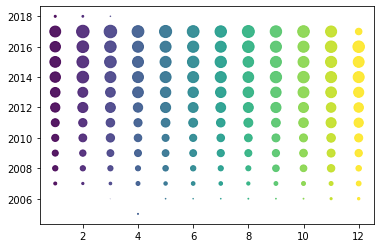

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
 
months = df_loans_month_year.month
years = df_loans_month_year.year
funded = df_loans_month_year.toal_funded_amount
 
# use the scatter function
plt.scatter(months, years, s=funded/100000, c=months, alpha=0.9)
plt.show()

## 16 <a class="anchor" id="country-gni">For each country, compute its overall GNI</a>
#### For each country, compute its overall GNI, by multiplying the per capita GNI with its population.
[⇑ index](#main)

We have seen that some countries doesn't have gni per capita. We will filter records with gni missing values.

In [81]:
df_countries[df_countries.gni.isnull()]

,country_name,country_code,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name
161,North Korea,KP,PRK,Asia,Eastern Asia,25490965,NaN,NaN,NaN,NaN,NaN,NaN,North Korea
164,Puerto Rico,PR,PRI,Americas,Caribbean,3663131,NaN,NaN,NaN,NaN,NaN,NaN,Puerto Rico
169,Somalia,SO,SOM,Africa,Eastern Africa,14742523,NaN,NaN,NaN,NaN,NaN,NaN,Somalia
171,Samoa,WS,WSM,Oceania,Polynesia,196440,NaN,0.702,NaN,NaN,NaN,NaN,Samoa
172,Palestine,PS,PS,Asia,Western Asia,4920724,NaN,0.677,NaN,NaN,NaN,NaN,Palestine
173,Kosovo,XK,NaN,Europe,Southern Europe,1895250,30.0,0.786,NaN,NaN,NaN,NaN,Kosovo


In [82]:
df_countries_gni = df_countries[df_countries.gni.notnull()][["country_name", "country_code", "gni", "population"]]
df_countries_gni

,country_name,country_code,gni,population
0,India,IN,5663.474799,1339180127
1,Nigeria,NG,5442.901264,190886311
2,Mexico,MX,16383.106680,129163276
3,Pakistan,PK,5031.173074,197015955
4,Bangladesh,BD,3341.490722,164669751
...,...,...,...,...
165,Qatar,QA,129915.600900,2639211
166,Saudi Arabia,SA,51320.113230,32938213
167,Singapore,SG,78162.323870,5708844
168,Solomon Islands,SB,1560.858813,611343


In [83]:
df_countries_total_gni = df_countries_gni.assign(total_gni=df_countries_gni.gni * df_countries_gni.population)
df_countries_total_gni

,country_name,country_code,gni,population,total_gni
0,India,IN,5663.474799,1339180127,7.584413e+12
1,Nigeria,NG,5442.901264,190886311,1.038975e+12
2,Mexico,MX,16383.106680,129163276,2.116096e+12
3,Pakistan,PK,5031.173074,197015955,9.912214e+11
4,Bangladesh,BD,3341.490722,164669751,5.502424e+11
...,...,...,...,...,...
165,Qatar,QA,129915.600900,2639211,3.428747e+11
166,Saudi Arabia,SA,51320.113230,32938213,1.690393e+12
167,Singapore,SG,78162.323870,5708844,4.462165e+11
168,Solomon Islands,SB,1560.858813,611343,9.542201e+08


# END OF MANDATORY EXERCISES

In [84]:
end_time = time.time()
print("NOTEBOOK EXECUTION TIME: " + str(end_time - start_time) + " seconds.")

NOTEBOOK EXECUTION TIME: 149.4683439731598 seconds.


## 17 <a class="anchor" id="country-irregular-repayment">Find the country with the highest rate of irregular repayment interval</a>
#### Find the country with the highest rate of irregular repayment interval.
[⇑ index](#main)

We already have fixed the missing values for the lenders countries in Exercise 9, so we can use again our **df_lenders_countries**. We also already have computed the distributed amount of funded loan by repayment_interval for each lender in **df_lenders_per_repayment_interval_status**

In [85]:
df_lenders_countries

,lender,country_code
0,qian3013,US
1,reena6733,DK
2,mai5982,CR
3,andrew86079135,NZ
4,nguyen6962,US
...,...,...
2349158,rakhi,US
2349159,vicki5374,US
2349161,jennifer5879,CA
2349171,maria2141,US


In [86]:
df_lenders_per_repayment_interval_status

repayment_interval,bullet,irregular,monthly,weekly
lender,,,,
000,143.343126,306.649935,1253.875351,NaN
00000,106.506211,550.240981,723.003055,NaN
0002,209.410885,1165.269449,1097.883232,NaN
00mike00,NaN,NaN,52.631579,NaN
0101craign0101,126.162029,531.016520,1966.386567,NaN
...,...,...,...,...
zzmcfate,5423.534534,19316.189964,38641.822208,NaN
zzpaghetti9994,NaN,NaN,51.020408,NaN
zzrvmf8538,NaN,66.969697,446.244022,NaN


In [87]:
df_lender_country_repayments = pd.merge(df_lenders_countries, df_lenders_per_repayment_interval_status.reset_index(), on="lender")
df_lender_country_repayments

,lender,country_code,bullet,irregular,monthly,weekly
0,qian3013,US,NaN,46.839080,NaN,NaN
1,reena6733,DK,NaN,32.471264,385.477101,NaN
2,andrew86079135,NZ,NaN,NaN,158.167522,NaN
3,sirinapa6764,US,NaN,NaN,50.000000,NaN
4,rene7585,PH,NaN,NaN,59.126984,NaN
...,...,...,...,...,...,...
1383794,rakhi,US,50.0,27.380952,67.032967,NaN
1383795,vicki5374,US,NaN,NaN,30.000000,NaN
1383796,jennifer5879,CA,NaN,NaN,35.869565,NaN
1383797,maria2141,US,NaN,83.333333,27.173913,NaN


In [88]:
df_lender_country_repayments.bullet = np.where(df_lender_country_repayments.bullet.isnull(), 0, df_lender_country_repayments.bullet)
df_lender_country_repayments.irregular = np.where(df_lender_country_repayments.irregular.isnull(), 0, df_lender_country_repayments.irregular)
df_lender_country_repayments.monthly = np.where(df_lender_country_repayments.monthly.isnull(), 0, df_lender_country_repayments.monthly)
df_lender_country_repayments.weekly = np.where(df_lender_country_repayments.weekly.isnull(), 0, df_lender_country_repayments.weekly)
df_lender_country_repayments

,lender,country_code,bullet,irregular,monthly,weekly
0,qian3013,US,0.0,46.839080,0.000000,0.0
1,reena6733,DK,0.0,32.471264,385.477101,0.0
2,andrew86079135,NZ,0.0,0.000000,158.167522,0.0
3,sirinapa6764,US,0.0,0.000000,50.000000,0.0
4,rene7585,PH,0.0,0.000000,59.126984,0.0
...,...,...,...,...,...,...
1383794,rakhi,US,50.0,27.380952,67.032967,0.0
1383795,vicki5374,US,0.0,0.000000,30.000000,0.0
1383796,jennifer5879,CA,0.0,0.000000,35.869565,0.0
1383797,maria2141,US,0.0,83.333333,27.173913,0.0


In [89]:
df_countries_per_repayment_interval_status = df_lender_country_repayments[["country_code", "bullet", "irregular", "monthly", "weekly"]].groupby(by=["country_code"]).sum()
df_countries_per_repayment_interval_status

,bullet,irregular,monthly,weekly
country_code,,,,
AD,376.808553,1378.673223,4.577309e+03,0.000000
AE,147541.807407,504236.604018,1.249115e+06,165.056022
AF,10394.686091,36677.608662,9.549396e+04,14.130435
AG,238.695038,489.161198,1.438830e+03,0.000000
AI,119.937421,38.461538,4.901847e+02,0.000000
...,...,...,...,...
YE,2606.497380,8339.822535,2.752656e+04,92.407834
YT,27.631579,358.794291,9.677221e+02,0.000000
ZA,57172.666910,212456.994007,4.415029e+05,18.421053


In [90]:
df_total_countries_repayments = df_countries_per_repayment_interval_status.bullet + df_countries_per_repayment_interval_status.irregular + df_countries_per_repayment_interval_status.monthly + df_countries_per_repayment_interval_status.weekly
df_countries_per_repayment_interval_status = df_countries_per_repayment_interval_status.assign(total=df_total_countries_repayments)
df_countries_per_repayment_interval_status

,bullet,irregular,monthly,weekly,total
country_code,,,,,
AD,376.808553,1378.673223,4.577309e+03,0.000000,6.332790e+03
AE,147541.807407,504236.604018,1.249115e+06,165.056022,1.901058e+06
AF,10394.686091,36677.608662,9.549396e+04,14.130435,1.425804e+05
AG,238.695038,489.161198,1.438830e+03,0.000000,2.166686e+03
AI,119.937421,38.461538,4.901847e+02,0.000000,6.485837e+02
...,...,...,...,...,...
YE,2606.497380,8339.822535,2.752656e+04,92.407834,3.856529e+04
YT,27.631579,358.794291,9.677221e+02,0.000000,1.354148e+03
ZA,57172.666910,212456.994007,4.415029e+05,18.421053,7.111509e+05


In [91]:
irregular_pc = (df_countries_per_repayment_interval_status.irregular / df_countries_per_repayment_interval_status.total) * 100
df_countries_per_repayment_interval_status = df_countries_per_repayment_interval_status.assign(irregular_percentage=irregular_pc)
df_countries_per_repayment_interval_status.sort_values(by=["irregular_percentage"], ascending=False)

,bullet,irregular,monthly,weekly,total,irregular_percentage
country_code,,,,,,
VU,15015.640576,229927.152926,101621.335266,0.0,346564.128768,66.344764
IO,0.000000,190.057405,128.466165,0.0,318.523570,59.668239
MR,0.000000,283.921198,219.210414,0.0,503.131612,56.430801
GZ,463.871624,5388.071188,3914.834984,0.0,9766.777796,55.167337
CD,803.959125,6568.556098,5111.866853,0.0,12484.382075,52.614187
...,...,...,...,...,...,...
MS,30.937500,0.000000,100.000000,0.0,130.937500,0.000000
FM,58.333333,0.000000,176.192584,0.0,234.525917,0.000000
NU,0.000000,0.000000,53.409091,0.0,53.409091,0.000000


## 18 <a class="anchor" id="country-frac-irregular-repayment">Find the country with the highest fraction of loaned amount with irregular repayment interval.</a>
#### Find the country with the highest fraction of loaned amount with irregular repayment interval
[⇑ index](#main)

In this exercise we considered the countries in respect of the borrowers, an information that we have already given from the df_loans dataset. In fact the countries of the lenders are in the df_lenders. So then, this is can be overtaken using a simple grouping by df_loans.

In [92]:
df_borrowed_countries_repayments = df_loans[["country_name", "repayment_interval", "funded_amount"]].groupby(by=["country_name", "repayment_interval"]).sum().reset_index()
df_borrowed_countries_repayments

,country_name,repayment_interval,funded_amount
0,Afghanistan,bullet,14000.0
1,Afghanistan,irregular,350.0
2,Afghanistan,monthly,1950300.0
3,Albania,bullet,44700.0
4,Albania,irregular,41500.0
...,...,...,...
233,Zambia,irregular,249250.0
234,Zambia,monthly,467900.0
235,Zimbabwe,bullet,5500.0
236,Zimbabwe,irregular,1710575.0


In [93]:
df_borrowed_countries_by_repayments = df_borrowed_countries_repayments.pivot(index="country_name", columns="repayment_interval", values="funded_amount").reset_index()
df_borrowed_countries_by_repayments

repayment_interval,country_name,bullet,irregular,monthly,weekly
0,Afghanistan,14000.0,350.0,1950300.0,NaN
1,Albania,44700.0,41500.0,3906275.0,NaN
2,Armenia,108800.0,671725.0,19504150.0,NaN
3,Azerbaijan,5000.0,2015175.0,12171175.0,NaN
4,Belize,1075.0,NaN,149100.0,NaN
...,...,...,...,...,...
91,Vietnam,343025.0,8507900.0,14612900.0,NaN
92,Virgin Islands,0.0,NaN,NaN,NaN
93,Yemen,NaN,264300.0,3075725.0,NaN
94,Zambia,1196100.0,249250.0,467900.0,NaN


In [94]:
df_borrowed_countries_by_repayments.bullet    = np.where(df_borrowed_countries_by_repayments.bullet.isnull(), 0, df_borrowed_countries_by_repayments.bullet   )
df_borrowed_countries_by_repayments.irregular = np.where(df_borrowed_countries_by_repayments.irregular.isnull(), 0, df_borrowed_countries_by_repayments.irregular)
df_borrowed_countries_by_repayments.monthly   = np.where(df_borrowed_countries_by_repayments.monthly.isnull(), 0, df_borrowed_countries_by_repayments.monthly  )
df_borrowed_countries_by_repayments.weekly    = np.where(df_borrowed_countries_by_repayments.weekly.isnull(), 0, df_borrowed_countries_by_repayments.weekly   )
df_borrowed_countries_by_repayments

repayment_interval,country_name,bullet,irregular,monthly,weekly
0,Afghanistan,14000.0,350.0,1950300.0,0.0
1,Albania,44700.0,41500.0,3906275.0,0.0
2,Armenia,108800.0,671725.0,19504150.0,0.0
3,Azerbaijan,5000.0,2015175.0,12171175.0,0.0
4,Belize,1075.0,0.0,149100.0,0.0
...,...,...,...,...,...
91,Vietnam,343025.0,8507900.0,14612900.0,0.0
92,Virgin Islands,0.0,0.0,0.0,0.0
93,Yemen,0.0,264300.0,3075725.0,0.0
94,Zambia,1196100.0,249250.0,467900.0,0.0


In [95]:
total_borrowed_countries_repayments = df_borrowed_countries_by_repayments.bullet + df_borrowed_countries_by_repayments.irregular + df_borrowed_countries_by_repayments.monthly + df_borrowed_countries_by_repayments.weekly
df_borrowed_countries_by_repayments = df_borrowed_countries_by_repayments.assign(total=total_borrowed_countries_repayments)
df_borrowed_countries_by_repayments = df_borrowed_countries_by_repayments.assign(irregular_frac=df_borrowed_countries_by_repayments.irregular / df_borrowed_countries_by_repayments.total)
df_borrowed_countries_by_repayments.sort_values(by=["irregular_frac"], ascending=False)

repayment_interval,country_name,bullet,irregular,monthly,weekly,total,irregular_frac
9,Botswana,0.0,8000.0,0.0,0.0,8000.0,1.0
63,Papua New Guinea,0.0,50000.0,0.0,0.0,50000.0,1.0
50,Mauritania,0.0,15000.0,0.0,0.0,15000.0,1.0
90,Vanuatu,0.0,9250.0,0.0,0.0,9250.0,1.0
89,Uruguay,0.0,8000.0,0.0,0.0,8000.0,1.0
...,...,...,...,...,...,...,...
28,Gaza,5000.0,0.0,0.0,0.0,5000.0,0.0
31,Guam,700.0,0.0,8000.0,0.0,8700.0,0.0
45,Lesotho,0.0,0.0,516450.0,0.0,516450.0,0.0
67,Puerto Rico,9600.0,0.0,353000.0,0.0,362600.0,0.0


In [96]:
df_borrowed_countries_by_repayments.sort_values(by=["irregular_frac"], ascending=False)[1:40]

repayment_interval,country_name,bullet,irregular,monthly,weekly,total,irregular_frac
63,Papua New Guinea,0.0,50000.0,0.0,0.0,50000.0,1.000000
50,Mauritania,0.0,15000.0,0.0,0.0,15000.0,1.000000
90,Vanuatu,0.0,9250.0,0.0,0.0,9250.0,1.000000
89,Uruguay,0.0,8000.0,0.0,0.0,8000.0,1.000000
16,Canada,0.0,50000.0,0.0,0.0,50000.0,1.000000
6,Bhutan,0.0,15625.0,0.0,0.0,15625.0,1.000000
73,Solomon Islands,0.0,806275.0,0.0,0.0,806275.0,1.000000
77,Sri Lanka,0.0,74800.0,0.0,0.0,74800.0,1.000000
21,Congo,0.0,2243775.0,12325.0,0.0,2256100.0,0.994537
18,Chile,0.0,2524825.0,24700.0,0.0,2549525.0,0.990312
